# Classification and prediction of topics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, accuracy_score, roc_curve, confusion_matrix
from sklearn import preprocessing
import itertools
from sklearn import metrics


%matplotlib inline
plt.style.use('ggplot')

In [2]:
topic_df = pd.read_csv('result_all_windows_labels.csv')
topic_df.head()

,0,label,1,2,3,4,5,6,7,8,...,28,29,30,label_w2v_no,label_w2v_scale,label_w2v_normalize,label_wmd_distance,label_wmd_normalize,label_wmd_scale,label_tfidf_normalize
0,2012_01_01,violence/terrorism,syrian,assad,say,syria,killed,damascus,people,regime,...,civilian,least,journalist,20,3,20,34,6,60,15
1,2012_01_02,misc,use,osc,copyrighted_material,dissemination,usage,reproduction,original,authorize,...,al,agency,location,36,6,25,49,2,60,46
2,2012_01_03,misc,will,year,can,people,one,country,party,make,...,change,political,just,15,15,19,10,3,60,8
3,2012_01_04,misc,quot,apos,say,the,we,it,reuters,terrorists,...,but,don,protest,38,25,10,20,23,60,6
4,2012_01_05,violence/terrorism,baghdad,iraq,sunni,killed,bomb,iraqi,attacks,wound,...,sadr,basra,near,26,5,11,18,14,60,29


dict_keys(['political', 'misc', 'violence/terrorism'])


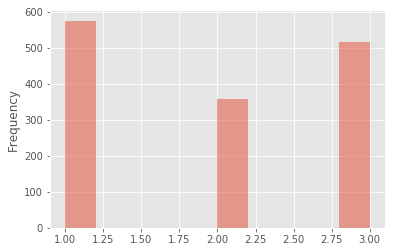

In [3]:

# Data cleanup
topic_df = topic_df[topic_df['label'].notnull()]
topic_df = topic_df[topic_df.label != 'environmental']
topic_df = topic_df[topic_df.label != 'religious']
topic_df = topic_df[topic_df.label != 'economical']

label_cat = {'violence/terrorism' : 1, 'misc': 2, 'political': 3,
#              'religious': 4, 'economical': 5, 'environmental': 6
            }
print(label_cat.keys()) 


def to_category(x):
    return label_cat[x]

topic_df['target'] = topic_df.apply(lambda row: to_category(row['label']), axis=1)

plt.figure()
topic_df['target'].plot.hist(alpha=0.5)
# Okay for now?


# topic_df

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Text Vector-representation (Bag of Words) 

In [5]:
topic_corpus = []

for index, row in topic_df.iloc[ :, 2:32].iterrows():
    topic_corpus.append(u' '.join(row.tolist()))

# topic_corpus

# Step 1: learn vocabulary of topics
vectorizer = CountVectorizer()
vectorizer.fit(topic_corpus)
# vectorizer.get_feature_names()

# Step 2: Vectorize the topic documents - dtm = document-token matrix
X_dtm = vectorizer.transform(topic_corpus)

# pd.DataFrame(data=X_dtm.toarray(), columns=vectorizer.get_feature_names(), index=topic_df['0'])

## Bag of Words

In [6]:
X = topic_corpus
y = topic_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [7]:
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))
# print(y)

1159 1159
290 290


In [8]:
vect = CountVectorizer(min_df=2)
# vect = TfidfVectorizer(norm='l2')
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)


# # normalized
# X_train_dtm = preprocessing.normalize(X_train_dtm, norm='l2')
# X_test_dtm = preprocessing.normalize(X_test_dtm, norm='l2')

# KNeighborsClassifier

accuracy:  0.7620689655172413
                    precision    recall  f1-score   support

         political       0.83      0.67      0.74       115
              misc       0.80      0.80      0.80        71
violence/terrorism       0.69      0.84      0.76       104

       avg / total       0.77      0.76      0.76       290

Confusion matrix, without normalization
[[77  8 30]
 [ 5 57  9]
 [11  6 87]]


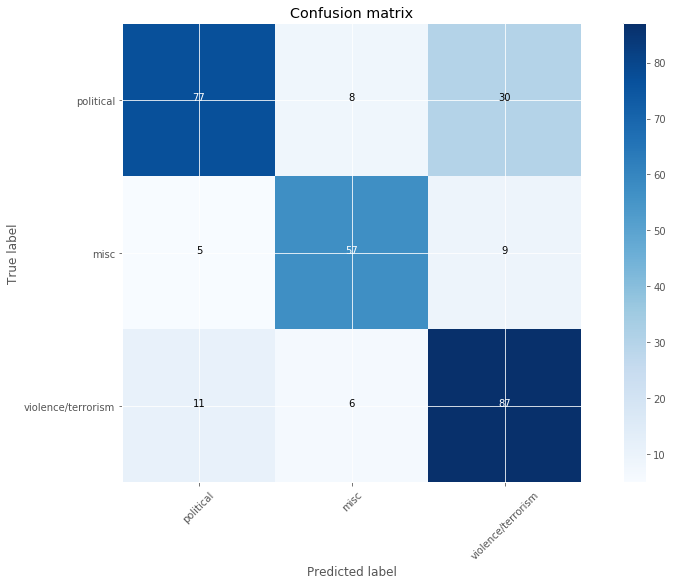

In [9]:
def kNeighours(X_train_dtm, X_test_dtm, y_train, y_test):
    from sklearn.neighbors import KNeighborsClassifier
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(X_train_dtm, y_train) 

    y_pred_test = neigh.predict(X_test_dtm)
    
    accuracy = accuracy_score(y_pred=y_pred_test, y_true=y_test)
    CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
    print('accuracy: ', accuracy)
    print(metrics.classification_report(y_test, y_pred_test, target_names=list(label_cat.keys())))
    
    # Plot normalized confusion matrix
    plt.figure(figsize=(12,8))
    plot_confusion_matrix(CM, classes=label_cat.keys(), title='Confusion matrix')
    plt.show()

    
    
kNeighours(X_train_dtm, X_test_dtm, y_train, y_test)

# NearestCentroid

accuracy:  0.7896551724137931
                    precision    recall  f1-score   support

         political       0.82      0.70      0.76       115
              misc       0.79      0.93      0.85        71
violence/terrorism       0.77      0.79      0.78       104

       avg / total       0.79      0.79      0.79       290

Confusion matrix, without normalization
[[81 10 24]
 [ 4 66  1]
 [14  8 82]]


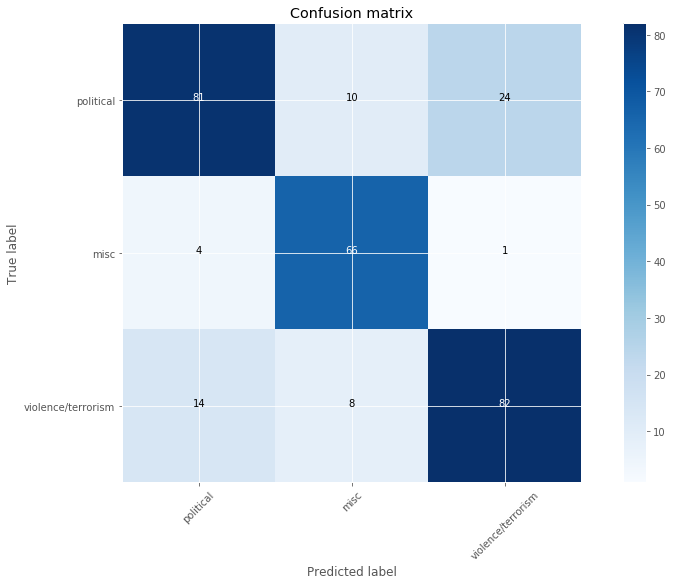

In [10]:
def nearestCentroid(X_train_dtm, X_test_dtm, y_train, y_test):
    from sklearn.neighbors.nearest_centroid import NearestCentroid

    clf = NearestCentroid()
    clf.fit(X_train_dtm, y_train)

    y_pred_test = clf.predict(X_test_dtm)
    
    accuracy = accuracy_score(y_pred=y_pred_test, y_true=y_test)
    CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
    print('accuracy: ', accuracy)
    print(metrics.classification_report(y_test, y_pred_test, target_names=list(label_cat.keys())))

    # Plot normalized confusion matrix
    plt.figure(figsize=(12,8))
    plot_confusion_matrix(CM, classes=label_cat.keys(), title='Confusion matrix')
    plt.show()
    
nearestCentroid(X_train_dtm, X_test_dtm, y_train, y_test)

# Multinomial classifier

accuracy:  0.8379310344827586
                    precision    recall  f1-score   support

         political       0.83      0.81      0.82       115
              misc       0.92      0.92      0.92        71
violence/terrorism       0.79      0.82      0.81       104

       avg / total       0.84      0.84      0.84       290

Confusion matrix, without normalization
[[93  2 20]
 [ 4 65  2]
 [15  4 85]]


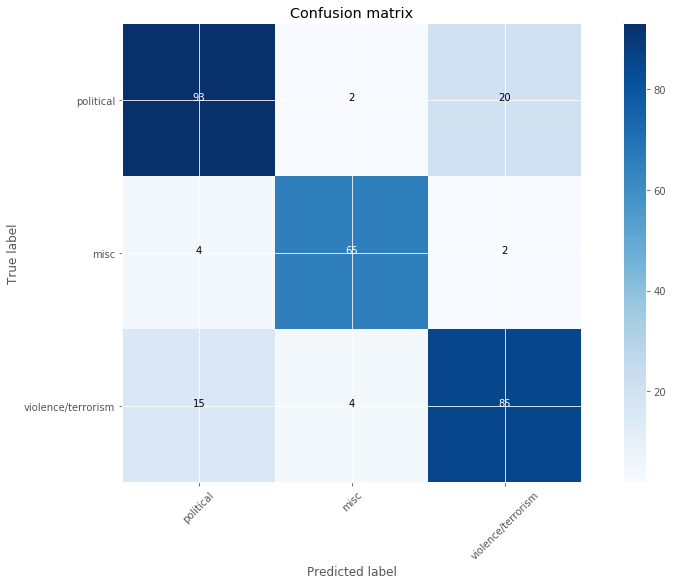

In [11]:

def multinomial(X_train_dtm, X_test_dtm, y_train, y_test):

    from sklearn.naive_bayes import MultinomialNB

    # Create instance of estimator
    nb = MultinomialNB()
    # Train the model
    nb.fit(X_train_dtm, y_train)
    # Evaluate
    y_pred_test = nb.predict(X_test_dtm)


    accuracy = accuracy_score(y_pred=y_pred_test, y_true=y_test)
    CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
    print('accuracy: ', accuracy)
    print(metrics.classification_report(y_test, y_pred_test, target_names=list(label_cat.keys())))

    # Plot normalized confusion matrix
    plt.figure(figsize=(12,8))
    plot_confusion_matrix(CM, classes=label_cat.keys(), title='Confusion matrix')
    plt.show()
    
multinomial(X_train_dtm, X_test_dtm, y_train, y_test)

## Logistic Regression

accuracy:  0.803448275862069
                    precision    recall  f1-score   support

         political       0.81      0.80      0.80       115
              misc       0.87      0.86      0.87        71
violence/terrorism       0.75      0.77      0.76       104

       avg / total       0.80      0.80      0.80       290

Confusion matrix, without normalization
[[92  3 20]
 [ 4 61  6]
 [18  6 80]]


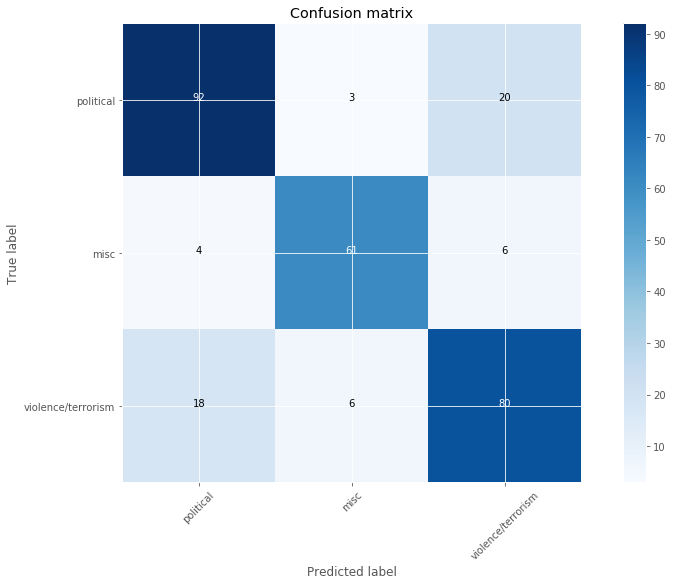

In [12]:
def logisticRegression(X_train_dtm, X_test_dtm, y_train, y_test):
    from sklearn.linear_model import LogisticRegression

    # Create instance of estimator
    logistic_regression = LogisticRegression(C=15, n_jobs=-1, random_state=15)
    # Train
    logistic_regression.fit(X_train_dtm, y_train)
    # Evaluate
    y_pred_test = logistic_regression.predict(X_test_dtm)

    accuracy = accuracy_score(y_pred=y_pred_test, y_true=y_test)
    CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
    print('accuracy: ', accuracy)
    print(metrics.classification_report(y_test, y_pred_test, target_names=list(label_cat.keys())))
    
    # Plot normalized confusion matrix
    plt.figure(figsize=(12,8))
    plot_confusion_matrix(CM, classes=label_cat.keys(), title='Confusion matrix')
    plt.show()
    
logisticRegression(X_train_dtm, X_test_dtm, y_train, y_test)

## Classification Trees

accuracy:  0.7103448275862069
                    precision    recall  f1-score   support

         political       0.87      0.59      0.70       115
              misc       0.64      0.86      0.73        71
violence/terrorism       0.66      0.74      0.70       104

       avg / total       0.74      0.71      0.71       290

Confusion matrix, without normalization
[[68 16 31]
 [ 1 61  9]
 [ 9 18 77]]


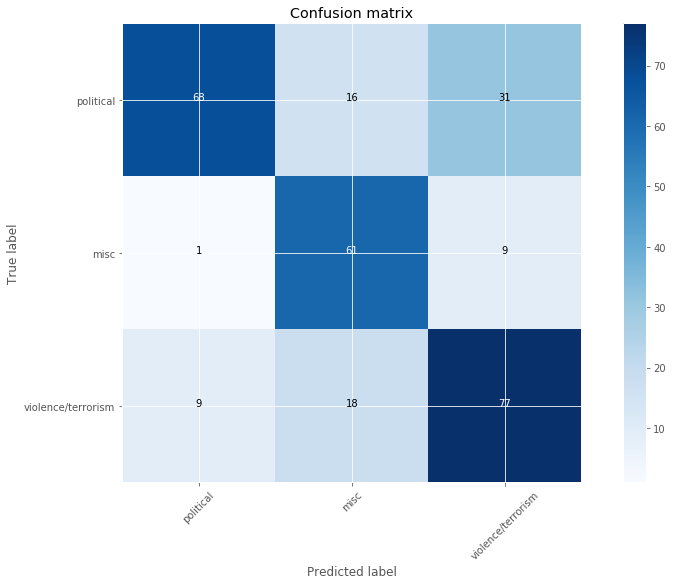

In [13]:
def tree(X_train_dtm, X_test_dtm, y_train, y_test):
    from sklearn.tree import DecisionTreeClassifier

    class_tree = DecisionTreeClassifier(max_depth=10, random_state=10)

    class_tree.fit(X_train_dtm, y_train)

    # Evaluate
    y_pred_test = class_tree.predict(X_test_dtm)

    accuracy = accuracy_score(y_pred=y_pred_test, y_true=y_test)
    CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
    print('accuracy: ', accuracy)
    print(metrics.classification_report(y_test, y_pred_test, target_names=list(label_cat.keys())))

    # Plot normalized confusion matrix
    plt.figure(figsize=(12,8))
    plot_confusion_matrix(CM, classes=label_cat.keys(), title='Confusion matrix')
    plt.show()
    
tree(X_train_dtm, X_test_dtm, y_train, y_test)

## Naive Bayes Classifier - GaussianNB

accuracy:  0.7896551724137931
                    precision    recall  f1-score   support

         political       0.77      0.77      0.77       115
              misc       0.87      0.86      0.87        71
violence/terrorism       0.76      0.76      0.76       104

       avg / total       0.79      0.79      0.79       290

Confusion matrix, without normalization
[[89  5 21]
 [ 6 61  4]
 [21  4 79]]


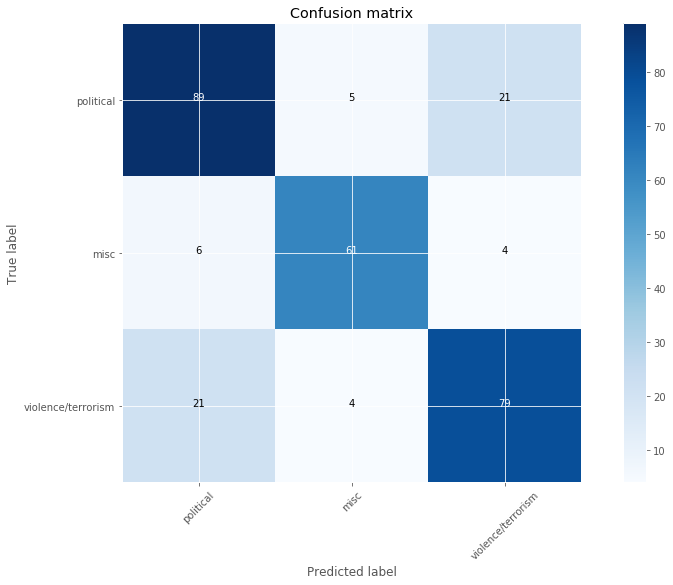

In [14]:
def gaussianNB(X_train_dtm, X_test_dtm, y_train, y_test):
    from sklearn.naive_bayes import GaussianNB

    # Create instance of estimator
    gnb = GaussianNB()
    # Train the model
    gnb.fit(X_train_dtm.toarray(), y_train)
    # Evaluate
    y_pred_test = gnb.predict(X_test_dtm.toarray())

    accuracy = accuracy_score(y_pred=y_pred_test, y_true=y_test)
    CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
    print('accuracy: ', accuracy)
    print(metrics.classification_report(y_test, y_pred_test, target_names=list(label_cat.keys())))

    # Plot normalized confusion matrix
    plt.figure(figsize=(12,8))
    plot_confusion_matrix(CM, classes=label_cat.keys(), title='Confusion matrix')
    plt.show()
    
gaussianNB(X_train_dtm, X_test_dtm, y_train, y_test)

# SVM

accuracy:  0.8
                    precision    recall  f1-score   support

         political       0.78      0.79      0.78       115
              misc       0.87      0.87      0.87        71
violence/terrorism       0.77      0.76      0.77       104

       avg / total       0.80      0.80      0.80       290

Confusion matrix, without normalization
[[91  3 21]
 [ 7 62  2]
 [19  6 79]]


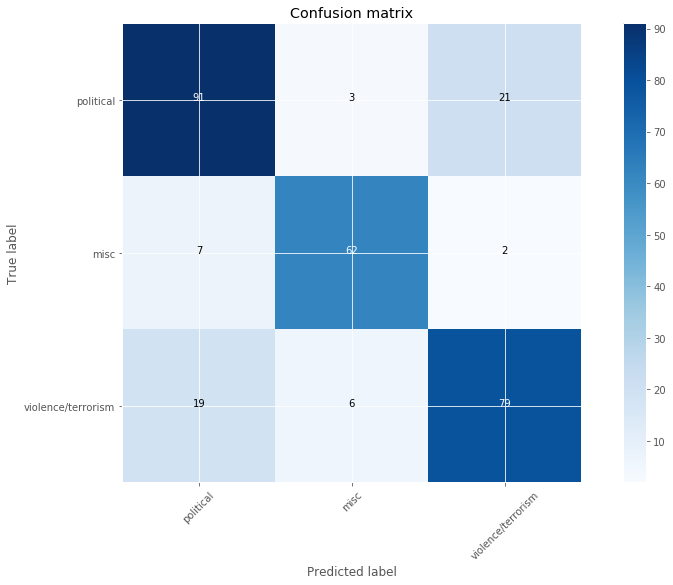

In [15]:
def svm (X_train_dtm, X_test_dtm, y_train, y_test):
    from sklearn.svm import SVC
    clf = SVC(kernel='linear')
    clf.fit(X_train_dtm, y_train)
    # Evaluate
    y_pred_test = clf.predict(X_test_dtm)
    
    accuracy = accuracy_score(y_pred=y_pred_test, y_true=y_test)
    CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
    print('accuracy: ', accuracy)
    print(metrics.classification_report(y_test, y_pred_test, target_names=list(label_cat.keys())))

    # Plot normalized confusion matrix
    plt.figure(figsize=(12,8))
    plot_confusion_matrix(CM, classes=label_cat.keys(), title='Confusion matrix')
    plt.show()
    
svm(X_train_dtm, X_test_dtm, y_train, y_test)


accuracy:  0.8172413793103448
                    precision    recall  f1-score   support

         political       0.81      0.81      0.81       115
              misc       0.89      0.87      0.88        71
violence/terrorism       0.78      0.79      0.78       104

       avg / total       0.82      0.82      0.82       290

Confusion matrix, without normalization
[[93  3 19]
 [ 5 62  4]
 [17  5 82]]


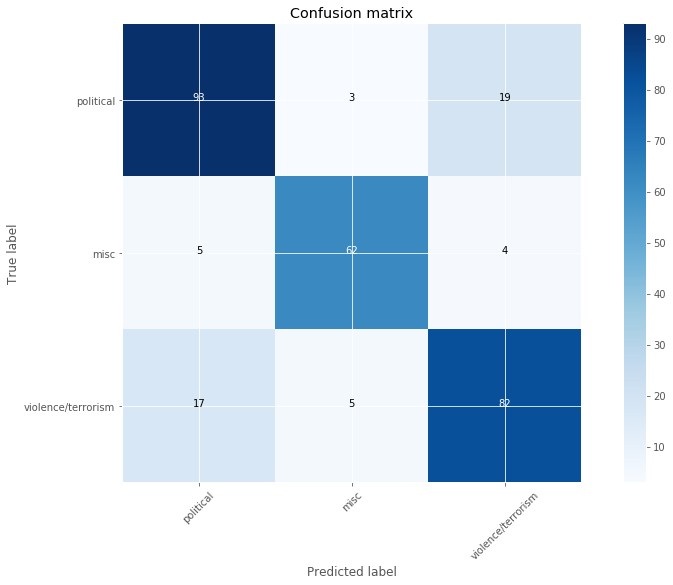

In [16]:
def randomForest (X_train_dtm, X_test_dtm, y_train, y_test):
    from sklearn.ensemble import RandomForestClassifier
    
    clf = RandomForestClassifier(max_depth=20, random_state=0)
    clf.fit(X_train_dtm, y_train)
    # Evaluate
    y_pred_test = clf.predict(X_test_dtm)
  
    accuracy = accuracy_score(y_pred=y_pred_test, y_true=y_test)
    CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
    print('accuracy: ', accuracy)
    print(metrics.classification_report(y_test, y_pred_test, target_names=list(label_cat.keys())))
    
    # Plot normalized confusion matrix
    plt.figure(figsize=(12,8))
    plot_confusion_matrix(CM, classes=label_cat.keys(), title='Confusion matrix')
    plt.show()
    
randomForest(X_train_dtm, X_test_dtm, y_train, y_test)



accuracy:  0.7068965517241379
                    precision    recall  f1-score   support

         political       0.69      0.70      0.70       115
              misc       0.87      0.68      0.76        71
violence/terrorism       0.64      0.73      0.68       104

       avg / total       0.72      0.71      0.71       290

Confusion matrix, without normalization
[[81  3 31]
 [12 48 11]
 [24  4 76]]


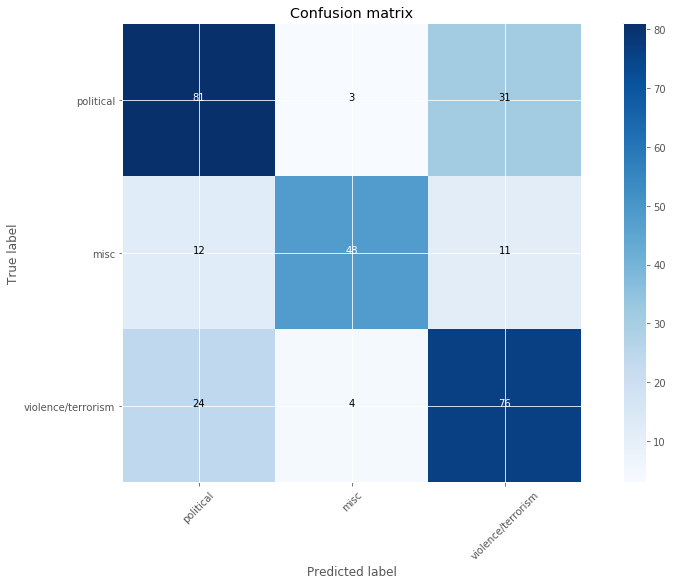

In [17]:
def adaBoostClassifier (X_train_dtm, X_test_dtm, y_train, y_test):
    from sklearn.ensemble import AdaBoostClassifier
    
    clf = AdaBoostClassifier(n_estimators=100)
    clf.fit(X_train_dtm, y_train)
    # Evaluate
    y_pred_test = clf.predict(X_test_dtm)

    accuracy = accuracy_score(y_pred=y_pred_test, y_true=y_test)
    CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
    print('accuracy: ', accuracy)
    print(metrics.classification_report(y_test, y_pred_test, target_names=list(label_cat.keys())))

    # Plot normalized confusion matrix
    plt.figure(figsize=(12,8))
    plot_confusion_matrix(CM, classes=label_cat.keys(), title='Confusion matrix')
    plt.show()
    
adaBoostClassifier(X_train_dtm, X_test_dtm, y_train, y_test)

accuracy:  0.7931034482758621
                    precision    recall  f1-score   support

         political       0.77      0.80      0.78       115
              misc       0.83      0.89      0.86        71
violence/terrorism       0.80      0.72      0.76       104

       avg / total       0.79      0.79      0.79       290

Confusion matrix, without normalization
[[92  8 15]
 [ 4 63  4]
 [24  5 75]]


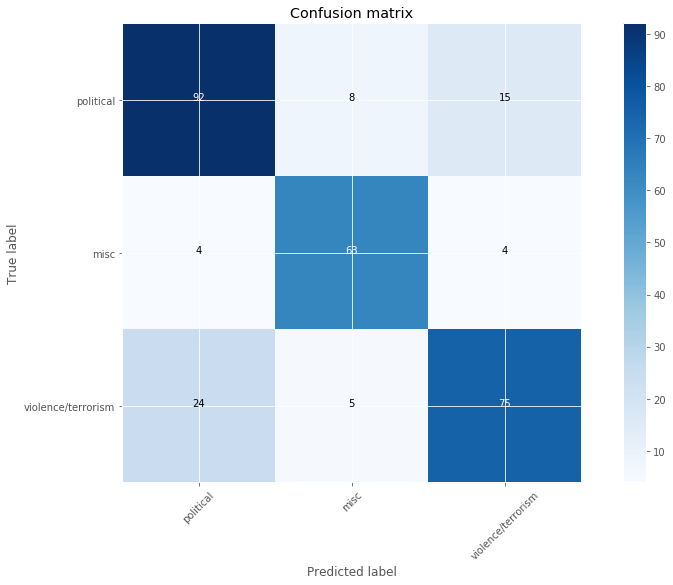

In [18]:

def SGDClassifier (X_train_dtm, X_test_dtm, y_train, y_test):
    from sklearn.linear_model import SGDClassifier
    
    clf =  SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42)
    clf.fit(X_train_dtm, y_train)
    # Evaluate
    y_pred_test = clf.predict(X_test_dtm)

    accuracy = accuracy_score(y_pred=y_pred_test, y_true=y_test)
    CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
    print('accuracy: ', accuracy)
    print(metrics.classification_report(y_test, y_pred_test, target_names=list(label_cat.keys())))

    # Plot normalized confusion matrix
    plt.figure(figsize=(12,8))
    plot_confusion_matrix(CM, classes=label_cat.keys(), title='Confusion matrix')
    plt.show()
    
SGDClassifier(X_train_dtm, X_test_dtm, y_train, y_test)



accuracy:  0.8103448275862069
                    precision    recall  f1-score   support

         political       0.81      0.79      0.80       115
              misc       0.88      0.89      0.88        71
violence/terrorism       0.77      0.78      0.78       104

       avg / total       0.81      0.81      0.81       290

Confusion matrix, without normalization
[[91  3 21]
 [ 5 63  3]
 [17  6 81]]


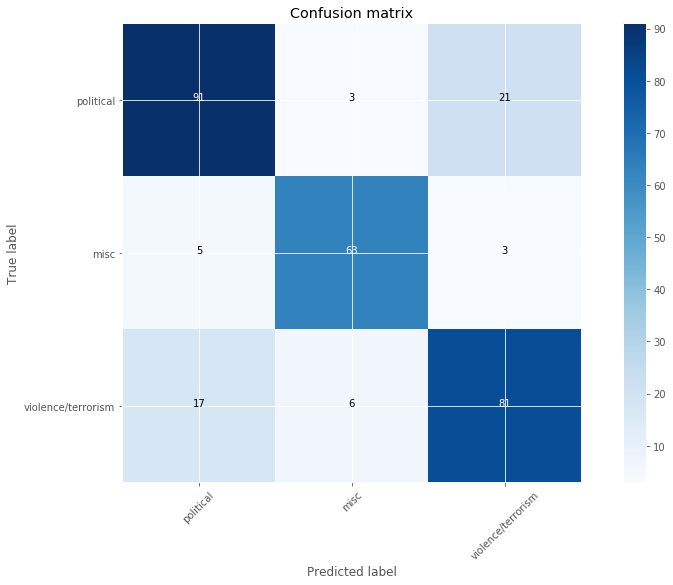

In [23]:


# https://www.kdnuggets.com/2016/10/beginners-guide-neural-networks-python-scikit-learn.html/2
def MLPClassifier (X_train_dtm, X_test_dtm, y_train, y_test):
    from sklearn.neural_network import MLPClassifier
    
    clf = MLPClassifier(hidden_layer_sizes=(30,30,30))
    clf.fit(X_train_dtm, y_train)
    # Evaluate
    y_pred_test = clf.predict(X_test_dtm)

    accuracy = accuracy_score(y_pred=y_pred_test, y_true=y_test)
    CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
    print('accuracy: ', accuracy)
    print(metrics.classification_report(y_test, y_pred_test, target_names=list(label_cat.keys())))

    # Plot normalized confusion matrix
    plt.figure(figsize=(12,8))
    plot_confusion_matrix(CM, classes=label_cat.keys(), title='Confusion matrix')
    plt.show()
    
MLPClassifier(X_train_dtm, X_test_dtm, y_train, y_test)




In [22]:
# def predict_topic(model, doc):
#     prediction = model.predict(vect.transform(doc))[0]
#     print(doc)
#     print(prediction)
    
# predict_topic(class_tree, ['hagel iraqi baghdad iraq forces abadi troop terry coalition kuwait secretary_chuck commander us army islamic_state defense train prime_minister advise james_terry obama security is_militant military lieutenant_general'])

In [20]:
# store the predicted probabilities for class 1
# y_pred_prob = logistic_regression.predict_proba(X_train_dtm)[:, 0]
# # histogram of predicted probabilities

# # 8 bins
# plt.hist(y_pred_prob, bins=8)

# # x-axis limit from 0 to 1
# plt.xlim(0,1)
# plt.title('Histogram of predicted probabilities')
# plt.xlabel('Predicted probability of topics')
# plt.ylabel('Frequency')